In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Visualization

Files already downloaded and verified
Files already downloaded and verified


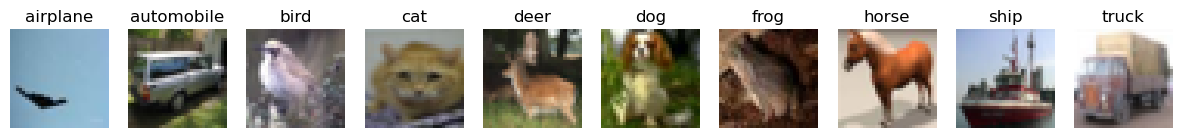

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = dataset.classes
data_iter = iter(train_loader)
images, labels = next(data_iter)

def show_images_in_row(images, labels, classes):
    plt.figure(figsize=(15, 2))  # Adjust the figure size for better visibility
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)  # Create subplots in a single row
        img = images[i] / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(classes[labels[i]])
        plt.axis('off')  # Remove axes for cleaner visualization
    plt.show()

images_per_class = []
labels_per_class = []
for i in range(10):  # Iterate over the 10 classes
    idx = (labels == i).nonzero(as_tuple=True)[0][0].item()  # Find one image of class i
    images_per_class.append(images[idx])
    labels_per_class.append(i)

show_images_in_row(images_per_class, labels_per_class, classes)


## Training Loop Function

In [4]:
def train_and_validate_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device, best_model_path):
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    return train_losses, val_losses, train_accuracies, val_accuracies


## Evaluation on Test Set Function

In [16]:
def evaluate_model(model, test_loader, device, class_names=None):

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Track total and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save predictions and labels for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = correct / total

    conf_matrix = confusion_matrix(all_labels, all_preds)

    return accuracy, conf_matrix

## Plot Loss and Accuracy per Epoch Function

In [19]:
def plot_training_validation_metrics(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies):

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

def plot_test_metrics(model, device):

    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

    test_accuracy, conf_matrix = evaluate_model(model, test_loader, device)

    print(f"Test Accuracy: {test_accuracy:.4f}")

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()


## Device

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Baseline Model

### Model

In [7]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

### Optimizer and Loss Function

In [8]:
baseline_model = BaselineModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline_model.parameters(), lr=0.01)

num_epochs = 30

### Training

In [9]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate_model(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    best_model_path="best_baseline_model.pth"
)

Epoch [1/30], Train Loss: 1.7964, Val Loss: 1.5926, Train Acc: 0.3736, Val Acc: 0.4489
Epoch [2/30], Train Loss: 1.4953, Val Loss: 1.4350, Train Acc: 0.4765, Val Acc: 0.4968
Epoch [3/30], Train Loss: 1.3670, Val Loss: 1.3636, Train Acc: 0.5214, Val Acc: 0.5231
Epoch [4/30], Train Loss: 1.2934, Val Loss: 1.3106, Train Acc: 0.5478, Val Acc: 0.5370
Epoch [5/30], Train Loss: 1.2398, Val Loss: 1.2993, Train Acc: 0.5696, Val Acc: 0.5383
Epoch [6/30], Train Loss: 1.1975, Val Loss: 1.2545, Train Acc: 0.5833, Val Acc: 0.5569
Epoch [7/30], Train Loss: 1.1582, Val Loss: 1.2232, Train Acc: 0.5988, Val Acc: 0.5704
Epoch [8/30], Train Loss: 1.1213, Val Loss: 1.2005, Train Acc: 0.6132, Val Acc: 0.5802
Epoch [9/30], Train Loss: 1.0898, Val Loss: 1.1989, Train Acc: 0.6266, Val Acc: 0.5752
Epoch [10/30], Train Loss: 1.0586, Val Loss: 1.1539, Train Acc: 0.6360, Val Acc: 0.5979
Epoch [11/30], Train Loss: 1.0340, Val Loss: 1.1469, Train Acc: 0.6442, Val Acc: 0.5988
Epoch [12/30], Train Loss: 1.0108, Val Lo

### Plot

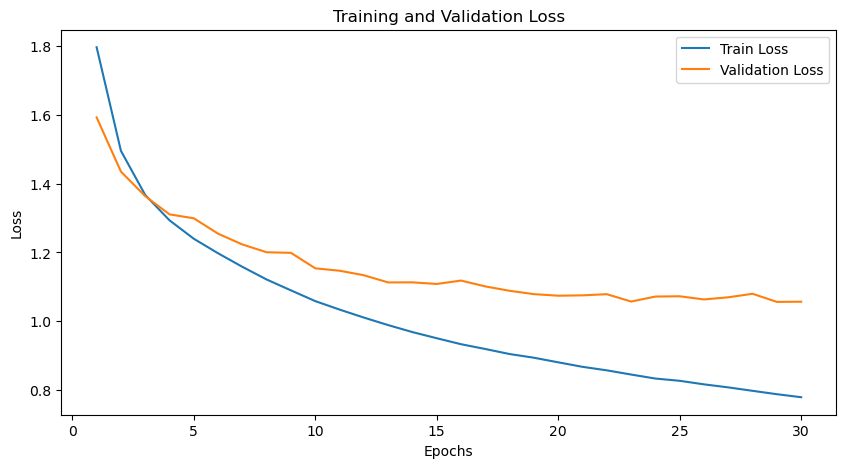

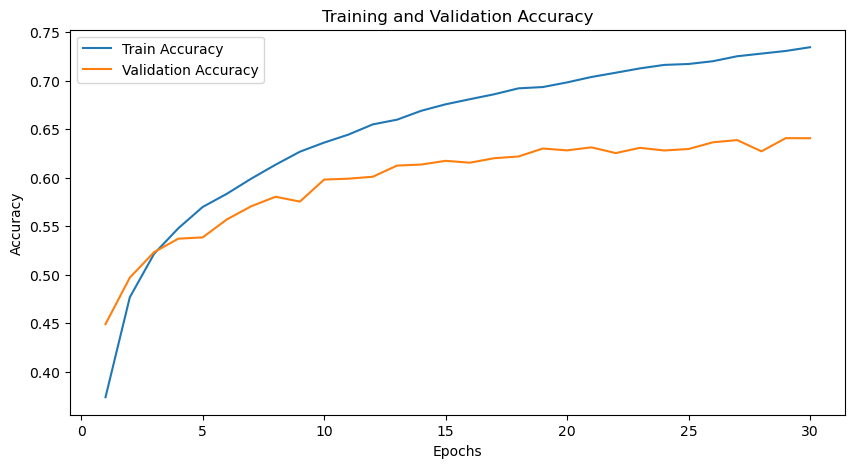

In [10]:
plot_training_validation_metrics(
    num_epochs=num_epochs,
    train_losses=train_losses,
    val_losses=val_losses,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies
)

### Test

Test Accuracy: 0.6485


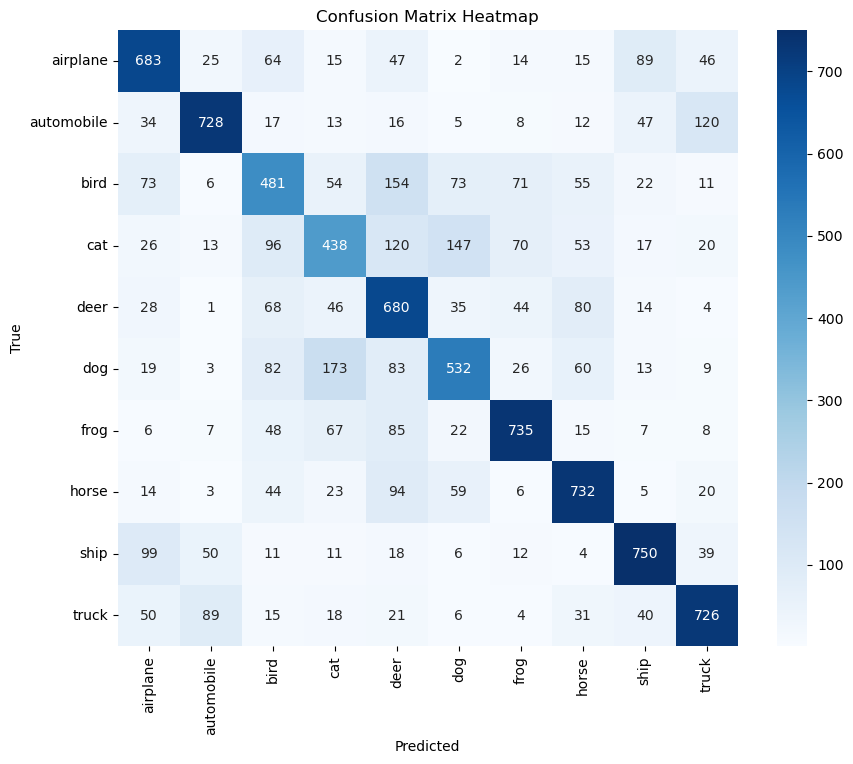

In [20]:
# Load the best model
model = BaselineModel().to(device)
model.load_state_dict(torch.load("best_baseline_model.pth"))

plot_test_metrics(model, device)

## Improved Model

### Model

In [100]:
import torch.nn as nn

class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # First conv layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # Second conv layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Third conv layer
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  # Fourth conv layer
        
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.tanh = nn.Tanh()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 2 * 2, 128)  # First FC layer
        self.fc2 = nn.Linear(128, 10)  # Second FC layer

    def forward(self, x):

        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv4(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        # Fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)  
        x = self.fc2(x)

        return x


### Optimizer and Loss Function

In [101]:
improved_model = ImprovedModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(improved_model.parameters(), lr=0.01)

num_epochs = 30

### Training

In [102]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate_model(
    model=improved_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    best_model_path="best_improved_model.pth"
)

Epoch [1/30], Train Loss: 2.3012, Val Loss: 2.2992, Train Acc: 0.1026, Val Acc: 0.1133
Epoch [2/30], Train Loss: 2.2893, Val Loss: 2.2657, Train Acc: 0.1588, Val Acc: 0.2102
Epoch [3/30], Train Loss: 2.0980, Val Loss: 1.9545, Train Acc: 0.2359, Val Acc: 0.2795
Epoch [4/30], Train Loss: 1.8656, Val Loss: 1.7786, Train Acc: 0.3240, Val Acc: 0.3576
Epoch [5/30], Train Loss: 1.7216, Val Loss: 1.6489, Train Acc: 0.3718, Val Acc: 0.3975
Epoch [6/30], Train Loss: 1.6050, Val Loss: 1.5814, Train Acc: 0.4120, Val Acc: 0.4230
Epoch [7/30], Train Loss: 1.5174, Val Loss: 1.4902, Train Acc: 0.4451, Val Acc: 0.4544
Epoch [8/30], Train Loss: 1.4423, Val Loss: 1.4156, Train Acc: 0.4778, Val Acc: 0.4823
Epoch [9/30], Train Loss: 1.3828, Val Loss: 1.3467, Train Acc: 0.4984, Val Acc: 0.5070
Epoch [10/30], Train Loss: 1.3285, Val Loss: 1.3266, Train Acc: 0.5211, Val Acc: 0.5226
Epoch [11/30], Train Loss: 1.2758, Val Loss: 1.2611, Train Acc: 0.5418, Val Acc: 0.5448
Epoch [12/30], Train Loss: 1.2256, Val Lo

### Plot

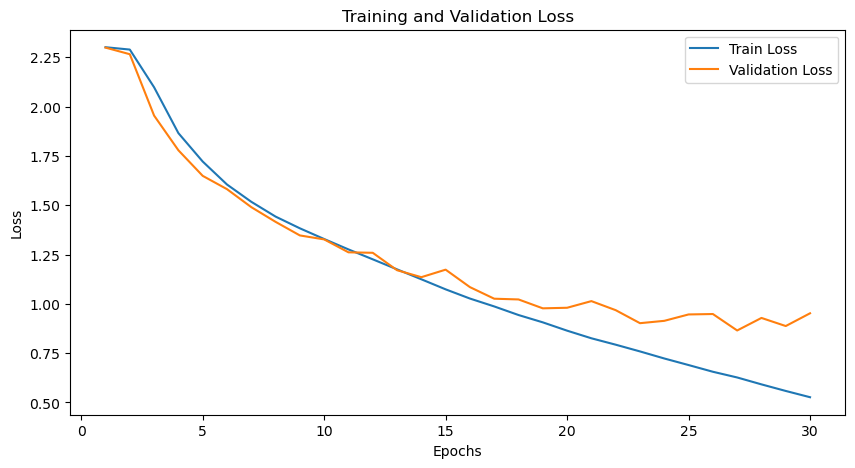

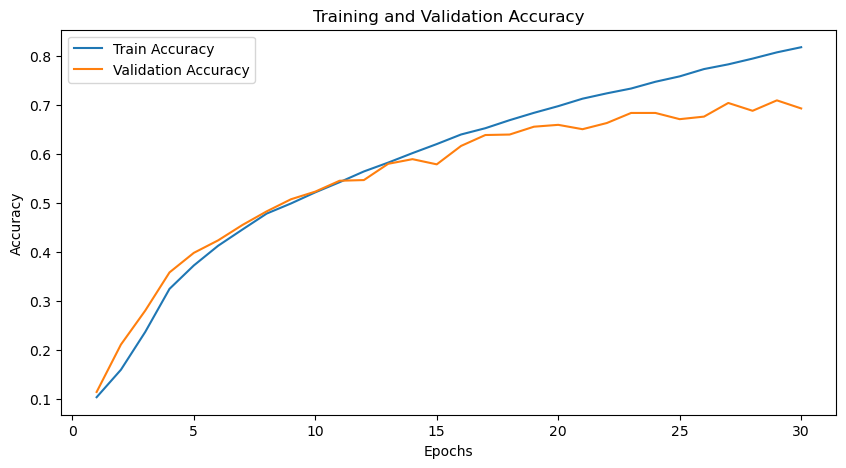

In [103]:
plot_training_validation_metrics(
    num_epochs=num_epochs,
    train_losses=train_losses,
    val_losses=val_losses,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies
)

### Test

Test Accuracy: 0.7115


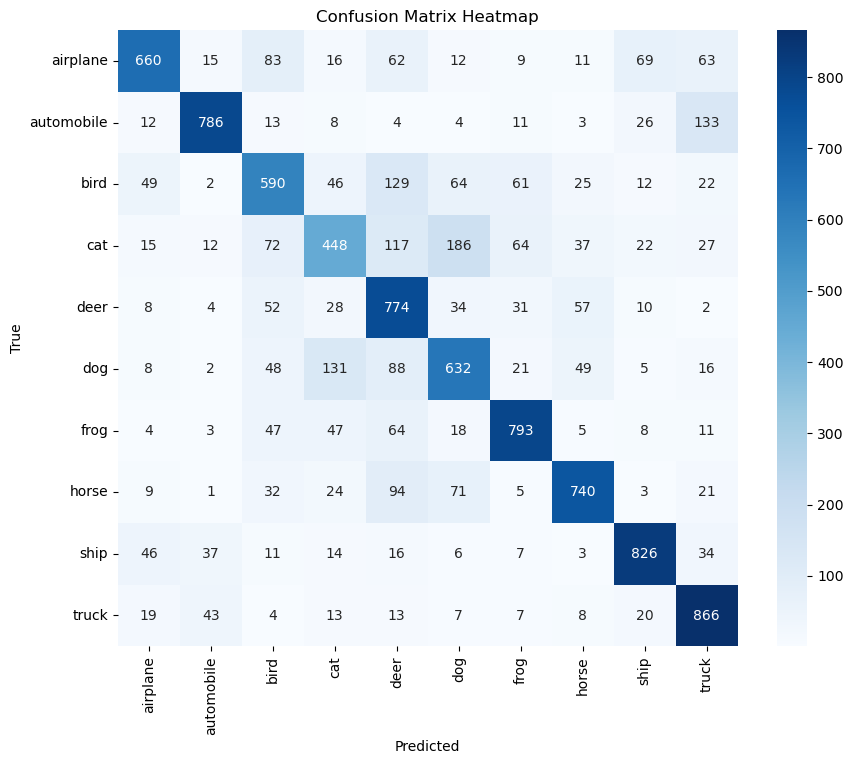

In [104]:
# Load the best model
model = ImprovedModel().to(device)
model.load_state_dict(torch.load("best_improved_model.pth"))

plot_test_metrics(model, device)

## Improved Model with Batch Normalization

### Model

In [108]:
import torch.nn as nn

class ImprovedModelWithBN(nn.Module):
    def __init__(self):
        super(ImprovedModelWithBN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  
        self.bn1 = nn.BatchNorm2d(32)  

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  
        self.bn2 = nn.BatchNorm2d(64)  

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  
        self.bn3 = nn.BatchNorm2d(128)  

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  
        self.bn4 = nn.BatchNorm2d(256)  
        
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.tanh = nn.Tanh()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)  

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 2 * 2, 128)  # First FC layer
        self.fc2 = nn.Linear(128, 10)  # Second FC layer

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)  
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)  
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.bn3(x)  
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv4(x)
        x = self.bn4(x)  
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        # Fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)  
        x = self.fc2(x)

        return x


### Optimizer and Loss Function

In [109]:
improved_model_with_BN = ImprovedModelWithBN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(improved_model_with_BN.parameters(), lr=0.01)

num_epochs = 30

### Training

In [110]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate_model(
    model=improved_model_with_BN,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    best_model_path="best_improved_model_with_BN.pth"
)

Epoch [1/30], Train Loss: 1.4597, Val Loss: 1.3864, Train Acc: 0.4777, Val Acc: 0.5086
Epoch [2/30], Train Loss: 1.0600, Val Loss: 1.0526, Train Acc: 0.6242, Val Acc: 0.6204
Epoch [3/30], Train Loss: 0.8890, Val Loss: 0.9422, Train Acc: 0.6880, Val Acc: 0.6648
Epoch [4/30], Train Loss: 0.7642, Val Loss: 0.9105, Train Acc: 0.7317, Val Acc: 0.6778
Epoch [5/30], Train Loss: 0.6640, Val Loss: 0.8975, Train Acc: 0.7691, Val Acc: 0.6911
Epoch [6/30], Train Loss: 0.5758, Val Loss: 0.8452, Train Acc: 0.7992, Val Acc: 0.7112
Epoch [7/30], Train Loss: 0.4921, Val Loss: 0.8253, Train Acc: 0.8296, Val Acc: 0.7155
Epoch [8/30], Train Loss: 0.4249, Val Loss: 0.8658, Train Acc: 0.8553, Val Acc: 0.7141
Epoch [9/30], Train Loss: 0.3587, Val Loss: 0.9036, Train Acc: 0.8800, Val Acc: 0.7169
Epoch [10/30], Train Loss: 0.2902, Val Loss: 0.9009, Train Acc: 0.9045, Val Acc: 0.7208
Epoch [11/30], Train Loss: 0.2308, Val Loss: 1.0039, Train Acc: 0.9243, Val Acc: 0.7045
Epoch [12/30], Train Loss: 0.1802, Val Lo

### Plot

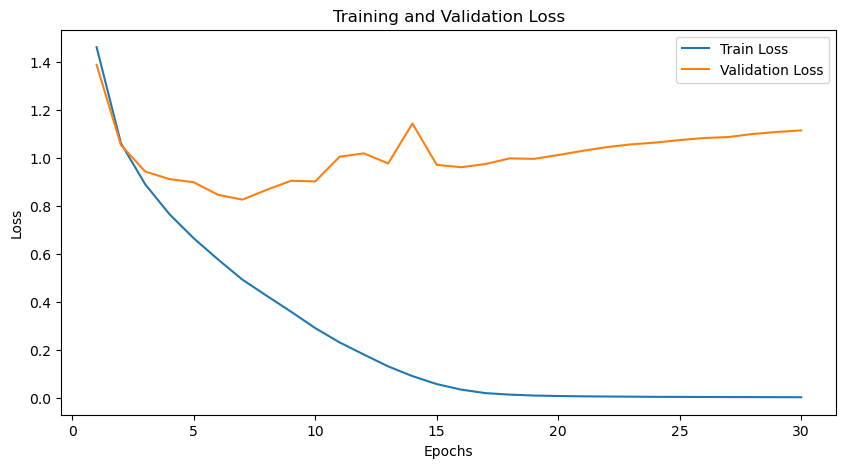

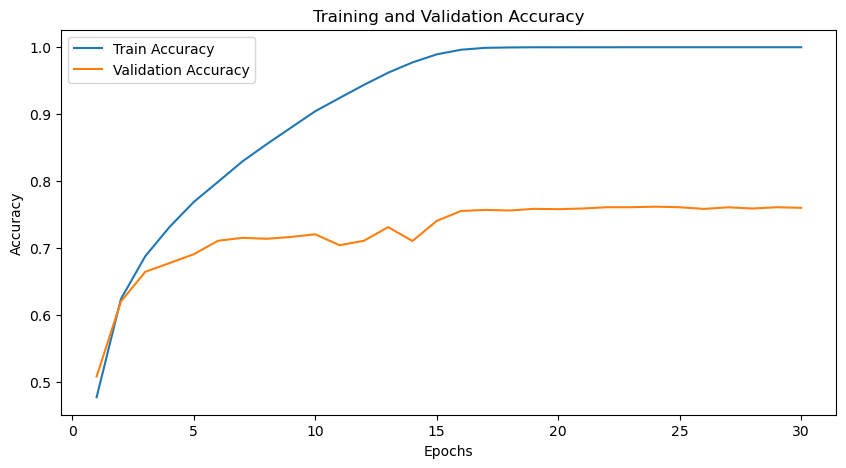

In [111]:
plot_training_validation_metrics(
    num_epochs=num_epochs,
    train_losses=train_losses,
    val_losses=val_losses,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies
)

In comparison with previous part, the validation loss decreases more and accuracy is higher. So, Batch Normalization improve the model's performance and by normalizing and reducing the mean, due to randomly choden data in minibatches, we can say we add noise to data and it helps generalization and performance is better.

### Test

Test Accuracy: 0.7283


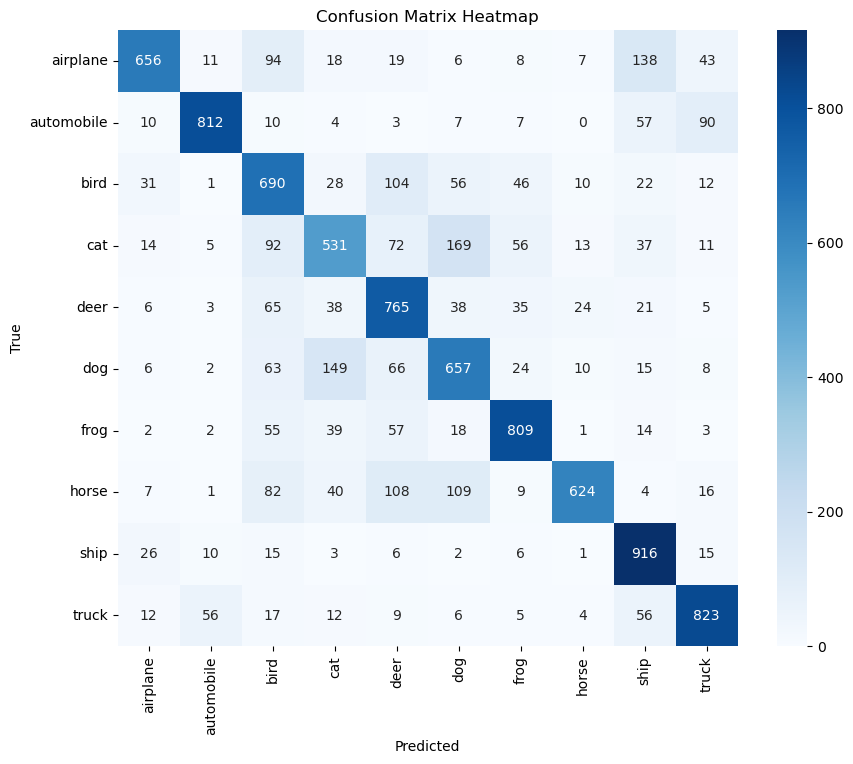

In [112]:
# Load the best model
model = ImprovedModelWithBN().to(device)
model.load_state_dict(torch.load("best_improved_model_with_BN.pth"))

plot_test_metrics(model, device)

## Improved Model with Batch Normalization and Dropout

### Model

In [131]:
import torch.nn as nn

class ImprovedModelWithBNandDropout(nn.Module):
    def __init__(self):
        super(ImprovedModelWithBNandDropout, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  
        self.bn1 = nn.BatchNorm2d(32)  

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  
        self.bn2 = nn.BatchNorm2d(64)  

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  
        self.bn3 = nn.BatchNorm2d(128)  

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  
        self.bn4 = nn.BatchNorm2d(256)  
        
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.tanh = nn.Tanh()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)  

        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.8)
        self.fc1 = nn.Linear(256 * 2 * 2, 128)  # First FC layer
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)  # Second FC layer

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)  
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)  
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.bn3(x)  
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv4(x)
        x = self.bn4(x)  
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        # Fully connected layers
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        return x

### Optimizer and Loss Function

In [132]:
improved_model_with_BN_and_Dropout = ImprovedModelWithBNandDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(improved_model_with_BN_and_Dropout.parameters(), lr=0.01)

num_epochs = 30

### Training

In [133]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate_model(
    model=improved_model_with_BN_and_Dropout,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    best_model_path="best_improved_model_with_BN_and_Dropout.pth"
)

Epoch [1/30], Train Loss: 1.9108, Val Loss: 1.6030, Train Acc: 0.2764, Val Acc: 0.4104
Epoch [2/30], Train Loss: 1.6174, Val Loss: 1.3977, Train Acc: 0.3856, Val Acc: 0.4905
Epoch [3/30], Train Loss: 1.4867, Val Loss: 1.3282, Train Acc: 0.4434, Val Acc: 0.5080
Epoch [4/30], Train Loss: 1.3815, Val Loss: 1.2021, Train Acc: 0.4891, Val Acc: 0.5696
Epoch [5/30], Train Loss: 1.3052, Val Loss: 1.1376, Train Acc: 0.5236, Val Acc: 0.5935
Epoch [6/30], Train Loss: 1.2337, Val Loss: 1.0785, Train Acc: 0.5523, Val Acc: 0.6191
Epoch [7/30], Train Loss: 1.1787, Val Loss: 1.0888, Train Acc: 0.5727, Val Acc: 0.5960
Epoch [8/30], Train Loss: 1.1318, Val Loss: 1.0263, Train Acc: 0.5911, Val Acc: 0.6299
Epoch [9/30], Train Loss: 1.0895, Val Loss: 0.9655, Train Acc: 0.6082, Val Acc: 0.6568
Epoch [10/30], Train Loss: 1.0574, Val Loss: 0.9610, Train Acc: 0.6177, Val Acc: 0.6542
Epoch [11/30], Train Loss: 1.0259, Val Loss: 0.9044, Train Acc: 0.6362, Val Acc: 0.6764
Epoch [12/30], Train Loss: 0.9934, Val Lo

### Plot

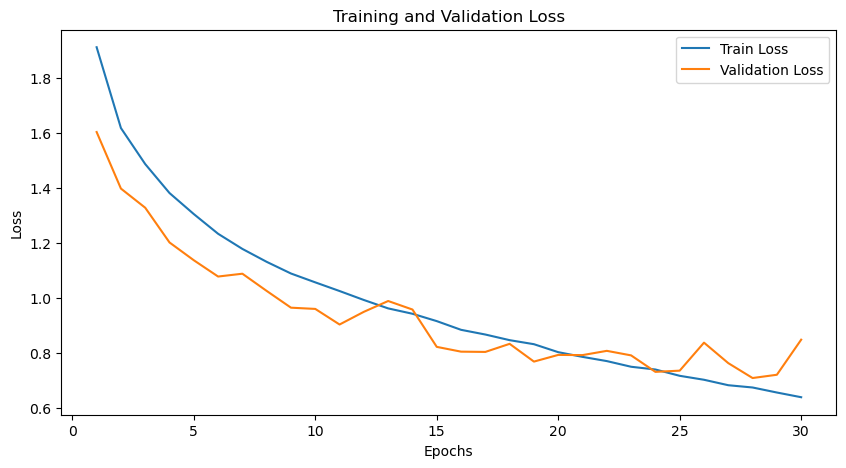

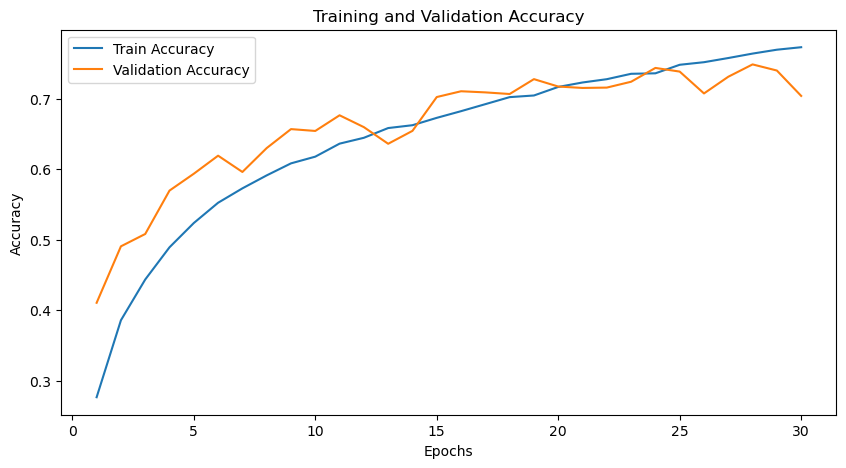

In [134]:
plot_training_validation_metrics(
    num_epochs=num_epochs,
    train_losses=train_losses,
    val_losses=val_losses,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies
)

We can see that dropout improves the performance of model. As we know, dropout is a regularization technique which helps generalization. The effect of dropout in my model architecture is more than batch normalization. However, the effect of BN may be more in other architectures.

### Test

Test Accuracy: 0.7491


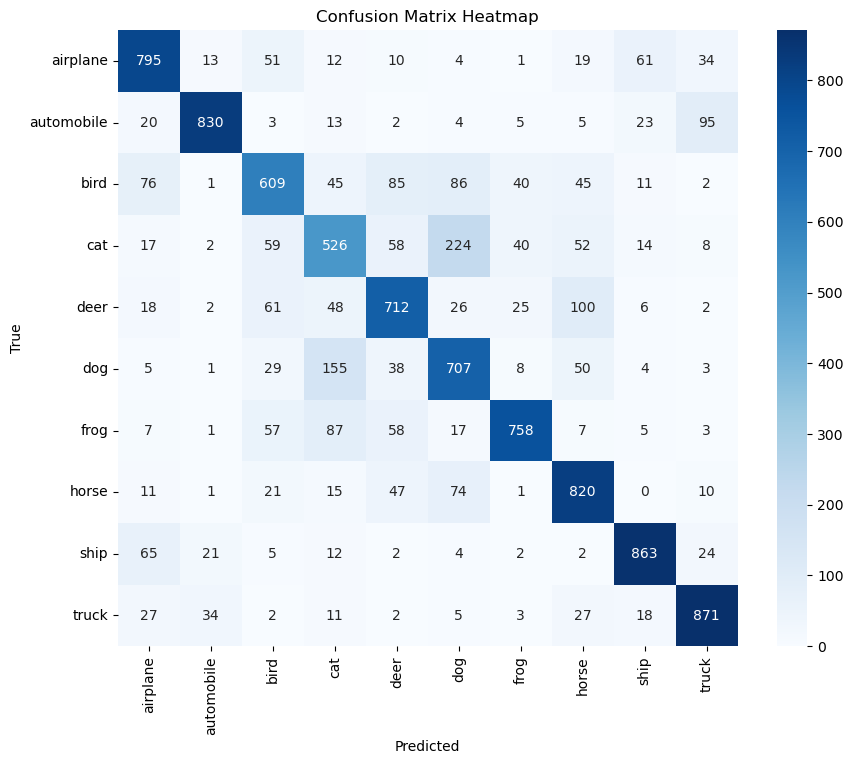

In [136]:
# Load the best model
model = ImprovedModelWithBNandDropout().to(device)
model.load_state_dict(torch.load("best_improved_model_with_BN_and_Dropout.pth"))

plot_test_metrics(model, device)